## FeedForwardNetwork(FFN)

Some functions will be used that were previously defined in Data Exploration file.

In [1]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

C:\Users\DEVARSHI\Anaconda3\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
C:\Users\DEVARSHI\Anaconda3\envs\tf-gpu\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


Here we are using feature extraction methods by appling librosa python library. The Methods involved are:

- Mel-frequency cepstral coefficients (MFCC): representation of the short-term power spectrum of a sound
- melspectrogram: Coefficients that collectively make up an mel-frequency cepstrum
- Chromagram of a short-time Fourier transform (chroma_stft): Projects into bins representing the 12 distinct semitones of the musical octave
- spectral_contrast (Octave-based spectral contrast) : Distribution of sound energy over octave frequencies 
- Tonnetz: Estimates tonal centroids features

In [2]:
def extract_features(file_name):
    X, sr = librosa.load(file_name)
    stft = np.abs(librosa.stft(X)) #Short-time Fourier transform (STFT)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sr).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sr).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_file(filename):
    mfccs, chroma, mel, contrast, tonnetz = extract_features(filename)
    features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    return features

Now lets test the dimensionality reduction with a sample file

In [3]:
def sample(filename):
    data_points, _ = librosa.load(filename)
    print ("Initial Data Points:", len(data_points))
    print('-'*30)
    
    mfccs, chroma, mel, contrast, tonnetz = extract_features(filename)
    all_features = np.hstack((mfccs,chroma,mel,contrast,tonnetz))
    print ("MFCSS features: ", len(mfccs))
    print ("Chroma features: ", len(chroma))
    print ("Mel spectogram features: ", len(mel))
    print ("Contrast features: ", len(contrast))
    print ("Tonnetz features: ", len(tonnetz))
    print ("Combined extracted features:", len(all_features))

test = r'C:\Users\DEVARSHI\Desktop\heartbeats-master\heartbeats-master\data\physionet\training-a\a0001.wav'
sample(test)

Initial Data Points: 786436
------------------------------
MFCSS features:  40
Chroma features:  12
Mel spectogram features:  128
Contrast features:  7
Tonnetz features:  6
Combined extracted features: 193


- 5 features will result in a vector of 193 value. This vector will always have the same length even if the audio files are of different length. 

- As it can be observed the input sound file had 786436 data point which is derived from sampaling rate of 22050 and it was reduced to 193 dimention points.

In [4]:
def parse_files(paths):
    
    save_path = os.path.join('data', 'physionet', 'reduced_features') # It will make new folder named reduced_features 
                                                                      # and saves .npy file 
    for path, df_name in paths:
        csv_path = os.path.join(path, 'REFERENCE.csv')
        df = pd.read_csv(csv_path, names = ['file', 'target'])
        df['file'] = df['file'].apply(lambda f: os.path.join(path,f + '.wav'))
        df['features'] = df['file'].apply(parse_file)
        df['target'] = df['target'].apply(lambda x: 1 if x == -1 else 0)
        
        feature_file = os.path.join(save_path, df_name + '_x.npy')
        label_file = os.path.join(save_path, df_name + '_y.npy')
        np.save(feature_file, np.array(df['features'].tolist()))
        np.save(label_file, np.array(df['target'].tolist()))
        
paths = [(os.path.join('data', 'physionet', 'training-a'), 'df_a'),
         (os.path.join('data', 'physionet', 'training-b'), 'df_b'), 
         (os.path.join('data', 'physionet', 'training-c'), 'df_c'),
         (os.path.join('data', 'physionet', 'training-d'), 'df_d'),
         (os.path.join('data', 'physionet', 'training-e'), 'df_e')]


#parse_files(paths)    # comment out this if you already have reduce feature files.

In [5]:
npfiles = [('df_a_x.npy','df_a_y.npy'),
           ('df_b_x.npy','df_b_y.npy'),
           ('df_c_x.npy','df_c_y.npy'),
           ('df_d_x.npy','df_d_y.npy'),
           ('df_e_x.npy','df_e_y.npy')]

data_save = r'C:\Users\DEVARSHI\Desktop\heartbeats-master\heartbeats-master\data\physionet\reduced_features'

from tqdm import tqdm

def load_npfiles(npfiles):
    concatenate = False
    for x, y in tqdm(npfiles):
        loaded_features = np.load(os.path.join(data_save, x))
        loaded_labels = np.load(os.path.join(data_save, y))
       
        if concatenate:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
            concatenate = True
    return features, labels
    
X, y = load_npfiles(npfiles)

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 455.65it/s]


### Training Neural Network

First we will split the dataset into training and testing.

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
from keras.models import Sequential
from keras import layers
import tensorflow as tf
import keras.backend as K
from tensorflow.keras import initializers


def create_model(dropout_rate=0.2):
    model = Sequential()
    model.add(layers.Dense(32, activation='relu', input_shape = (193,)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

Using TensorFlow backend.


In [8]:
model = create_model()

Here 3 layers are used, in which first and second layer has 32 neurons with dense connections and last layer has 1 neuron. Activation fuctionis relu and sigmoid respectively. Drope out rate is set to 20%, which will randomly ignore 20% connection of dense network. Optimizer is Adam for faster convergence.

### Training model

In [9]:
history = model.fit(x_train, y_train, epochs=40, batch_size=32, validation_data=(x_test, y_test))

Train on 2344 samples, validate on 782 samples
Epoch 1/40
2344/2344 [==============================] - ETA: 21s - loss: 4.2604 - accuracy: 0.843 - ETA: 0s - loss: 4.4846 - accuracy: 0.700 - ETA: 0s - loss: 3.3200 - accuracy: 0.70 - ETA: 0s - loss: 2.8982 - accuracy: 0.70 - 1s 239us/step - loss: 2.6598 - accuracy: 0.7086 - val_loss: 0.6074 - val_accuracy: 0.7954
Epoch 2/40
2344/2344 [==============================] - ETA: 0s - loss: 0.9387 - accuracy: 0.75 - ETA: 0s - loss: 1.2385 - accuracy: 0.75 - ETA: 0s - loss: 1.0914 - accuracy: 0.75 - ETA: 0s - loss: 1.1144 - accuracy: 0.76 - ETA: 0s - loss: 1.0353 - accuracy: 0.76 - 0s 125us/step - loss: 0.9618 - accuracy: 0.7692 - val_loss: 0.3641 - val_accuracy: 0.8325
Epoch 3/40
2344/2344 [==============================] - ETA: 0s - loss: 0.4967 - accuracy: 0.75 - ETA: 0s - loss: 0.7469 - accuracy: 0.74 - ETA: 0s - loss: 0.6834 - accuracy: 0.75 - ETA: 0s - loss: 0.6353 - accuracy: 0.77 - 0s 102us/step - loss: 0.6114 - accuracy: 0.7799 - val_lo

2344/2344 [==============================] - ETA: 0s - loss: 0.1278 - accuracy: 0.90 - ETA: 0s - loss: 0.2267 - accuracy: 0.90 - ETA: 0s - loss: 0.2295 - accuracy: 0.90 - ETA: 0s - loss: 0.2295 - accuracy: 0.90 - 0s 95us/step - loss: 0.2299 - accuracy: 0.9006 - val_loss: 0.3727 - val_accuracy: 0.8977
Epoch 27/40
2344/2344 [==============================] - ETA: 0s - loss: 0.1562 - accuracy: 0.96 - ETA: 0s - loss: 0.2137 - accuracy: 0.90 - ETA: 0s - loss: 0.2061 - accuracy: 0.90 - ETA: 0s - loss: 0.2136 - accuracy: 0.90 - 0s 96us/step - loss: 0.2217 - accuracy: 0.9002 - val_loss: 0.3970 - val_accuracy: 0.9003
Epoch 28/40
2344/2344 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.93 - ETA: 0s - loss: 0.2428 - accuracy: 0.90 - ETA: 0s - loss: 0.2398 - accuracy: 0.89 - ETA: 0s - loss: 0.2274 - accuracy: 0.90 - 0s 96us/step - loss: 0.2265 - accuracy: 0.9083 - val_loss: 0.4391 - val_accuracy: 0.8747
Epoch 29/40
2344/2344 [==============================] - ETA: 0s - los

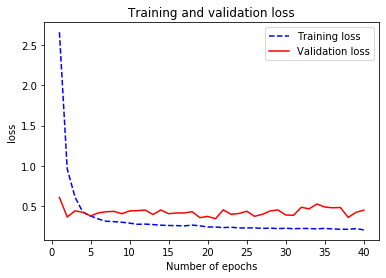

In [10]:
epochs = range(1, 41)
plt.figure()
plt.plot(epochs, history.history['loss'], 'b--', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

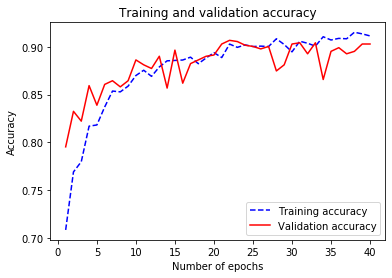

In [11]:
plt.figure()
plt.plot(epochs, history.history['accuracy'], 'b--', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Gridsearch
We will use GridSearch to train separate instances of a model with different hyperparameters. Then, we will compare results to identify which combination of parameters produces the best resutls.

In [12]:
def evaluate(model, x_test, y_test):
    y_pred = model.predict_classes(x_test)

    score, accuracy = model.evaluate(x_test, y_test, batch_size=32)
    print ("\nAccuracy:", accuracy)

    p = precision_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print ("Precision:", p)
    print ("Recall:", r)
    print ("F-Score:", f1)
    print ("Confusion Matrix:")
    print (confusion_matrix(y_test, y_pred))
    
evaluate(model, x_test, y_test)

782/782 [==============================] - ETA:  - 0s 41us/step

Accuracy: 0.9028133153915405
Precision: 0.9247311827956989
Recall: 0.9570747217806042
F-Score: 0.9406249999999999
Confusion Matrix:
[[104  49]
 [ 27 602]]


In [16]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=create_model)

epochs = [10, 20, 30, 40]
dropout_rate = [0.1, 0.2, 0.3, 0.4, 0.5]
batch_size = [32]
param_grid = dict(dropout_rate=dropout_rate, epochs=epochs, batch_size = batch_size)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', verbose=0)

grid_result = grid.fit(x_train, y_train, verbose=0)

print ("Best accuracy: {0} using parameters {1}".format(grid_result.best_score_, grid_result.best_params_))

Best accuracy: 0.9413015194140919 using parameters {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 40}


In [17]:
# model.load_weights('models/ffn.hdf5') # load weights to model

## Results

Here Best parameters are according to gridsearch:
<li>epochs: 40</li>
<li>dropout rate: 0.1</li>
<li>batch size: 32</li>
<li>Accuracy: 94.13%</li>